In [4]:
import itertools
from pathlib import Path

import numpy as np
import torch

from zsl_config import ZSL_DIR_ANALYSIS
from zsl_utils.mpl import *

In [5]:
MODEL_CLASS = 'olmo'
DATASET = 'c4_en_val'
ANALYSIS_NAME = 'grad_intrf'

RUNS = [
        '1028-rmsnorm-14m',
        '1028-rmsnorm-37m',
        '1028-rmsnorm-78m',
        '1028-rmsnorm-144m',
        '1028-rmsnorm-285m',
        '1028-rmsnorm-472m',
    ]

VERBOSE = True
OVERWRITE = False

OUT_DIR = ZSL_DIR_ANALYSIS / ANALYSIS_NAME
assert OUT_DIR.exists()

FIG_DIR = Path.cwd() / "fig"
FIG_DIR.mkdir(exist_ok=True)

# Visualization

In [ ]:
def load_grad_intrf(run, drop_embed=True, device='cpu'):
    f = OUT_DIR / f'gdi_metrics_{run}.pt'
    step_metrics = torch.load(f, map_location=device)
    metrics_meta = step_metrics.pop('meta')
    grad_intrf = []
    steps = []
    for step, param_metrics in step_metrics.items():
        gdi_accum = 0
        n_accum = 0
        for param, metrics in param_metrics.items():
            if drop_embed and 'wte' in param:
                continue
            n = metrics_meta['numel'][param]
            n_accum += n
            gdi_accum += metrics['gdi_mean'] * n
        
        grad_intrf += [gdi_accum / n_accum]
        steps += [step]

    return steps, grad_intrf
    

x,y = load_grad_intrf(RUNS[0])

/tmp/ipykernel_4140131/2005476864.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  step_metrics = torch.load(f, map_location=device)


## Destructive interference

/tmp/ipykernel_4140131/2005476864.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  step_metrics = torch.load(f, map_location=device)


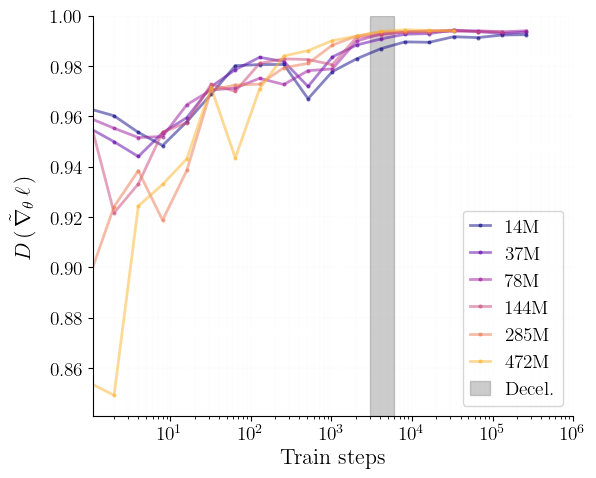

In [27]:
get_fp = lambda n: FIG_DIR / f'grad_intrf/{n}'


def plot_data(ax, run, model_size):
    color = get_color(RUNS.index(run), vmax=len(RUNS))
    steps,  grad_intrf = load_grad_intrf(run)
    ax.plot(steps, grad_intrf, alpha=0.5, color=color, marker='o', linewidth=2, ms=2, label=model_size)
    return ax

def format_plot(fig, ax, ylabel=None):
    xlabel = 'Train steps'
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_xlim(1.1, 1e6)
    # HACK: make sure log scale ticks/grids are visible
    ax.xaxis.set_major_locator(mtick.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mtick.LogLocator(numticks=999, subs="auto"))

    ax.set_ylabel(ylabel)
    ax.set_yscale('linear')
    ax.set_ylim(0.841, 1)
    ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1))
    ax.yaxis.labelpad = 10

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linewidth=0.1, alpha=0.4, color='gray', linestyle='dotted', which='both')

    # remove decel if already exists
    for p in ax.patches:
        if p.get_label() == 'Decel.':
            p.remove()
    ax.axvspan(3000, 6000, color='gray', alpha=0.4, label='Decel.')
    ax.legend(handlelength=1, fontsize=14)

    fig.set_size_inches(*FIGSIZE_MED)
    plt.close(fig)
    fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
    return fig, ax

fig_path = get_fp(f'D.pdf')
fig_path.parent.mkdir(parents=True, exist_ok=True)
fig, ax = plt.subplots()
for i, run in enumerate(RUNS):
    model_size = run.split('-')[-1].replace('m', 'M')
    ax = plot_data(ax, run, model_size)

ylabel = '$D\,(\,\\tilde\\nabla_{\\theta} \, \ell\,)$'
fig, ax = format_plot(fig, ax, ylabel)
save_figure(fig, fig_path, save_json=False, save_png=False)
display(fig)